In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

from vecstack import stacking

from tensorflow.python.keras import layers,models, callbacks 
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.classifier import ROCAUC

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'Gulim'
plt.rcParams["font.family"]

from sklearn.externals import joblib

# 최종 데이터 불러오기

In [0]:
data = pd.read_csv('total_dataset_ver1.csv')
data.head()

,운행일자,요일,열차번호,역,출도착구분,역간소요시간,누적소요시간,급행여부,환승가능,출발행,종착행,방향,지연여부,시간,승차,하차,기온(°C),기온 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조 QC플래그,전운량(10분위),중하층운량(10분위),시정(10m),지면온도(°C),지면온도 QC플래그
0,20191101,금,K1907,수원,정차,7.0,41.5,1,2,용산,천안,하행,True,11~12,1800.0,2375.0,14.5,0.0,1.0,0.0,160.0,0.0,50.0,0.0,8.2,4.1,1025.3,0.0,1029.5,0.0,0.0,0.0,0.0,1195.0,11.5,0.0
1,20191101,금,K1907,수원,정차,7.0,41.5,1,2,용산,천안,하행,True,11~12,1800.0,2375.0,14.5,0.0,1.0,0.0,160.0,0.0,50.0,0.0,8.2,4.1,1025.3,0.0,1029.5,0.0,0.0,0.0,0.0,1195.0,11.5,0.0
2,20191101,금,K1907,수원,정차,7.0,41.5,1,2,용산,천안,하행,True,11~12,1800.0,2375.0,14.5,0.0,1.0,0.0,160.0,0.0,50.0,0.0,8.2,4.1,1025.3,0.0,1029.5,0.0,0.0,0.0,0.0,1195.0,11.5,0.0
3,20191101,금,K1907,수원,정차,7.0,41.5,1,2,용산,천안,하행,True,11~12,1800.0,2375.0,14.5,0.0,1.0,0.0,160.0,0.0,50.0,0.0,8.2,4.1,1025.3,0.0,1029.5,0.0,0.0,0.0,0.0,1195.0,11.5,0.0
4,20191101,금,K1907,세류,통과,2.5,44.0,1,0,용산,천안,하행,True,11~12,147.0,135.0,14.5,0.0,1.0,0.0,160.0,0.0,50.0,0.0,8.2,4.1,1025.3,0.0,1029.5,0.0,0.0,0.0,0.0,1195.0,11.5,0.0


- 분석을 진행하기 전에 분석에 맞는 데이터로 변환

In [0]:
class PreWork:
    
    def __init__(self, data, cols):
        self.data = data
        self.cols = cols

    def chg_category(self):
        for col in self.cols:
            self.data[col] = pd.factorize(self.data[col])[0]
        
        return self.data

    
    def split_delete_data(self, test_size):  
        
        self.data = self.chg_category()
        
        
        # split data
        # 11월 25일 이후를 예측하는 것이 문제!!
        # new_data는 앞으로 우리가 예측해야할 대상
        # orig_data는 학습시킬 대상
        new_data = self.data[self.data['운행일자'] > 20191124] # 새로운 데이터로, 우리가 예측해야할 대상
        orig_data = self.data[self.data['운행일자'] <= 20191124]
        
        # 운행일자 제거
        new_data.drop(['운행일자'], axis = 1, inplace = True)
        orig_data.drop(['운행일자'], axis = 1, inplace = True)
        
        
        # X, y
        X = orig_data.drop(['지연여부'], axis = 1)
        y = orig_data['지연여부']
        print('#############################')
        print('y의 비율은')
        print(y.value_counts(normalize = True))
        print(' ')
        print(' ')
        
        
        # new_X, new_y
        new_X = new_data.drop(['지연여부'], axis = 1)
        new_y = new_data['지연여부']
        print('#############################')
        print('new_y의 비율은')
        print(new_y.value_counts(normalize = True))
        print(' ')
        print(' ')

        # split train, test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 11)
        
        # scale
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        new_X = scaler.transform(new_X)
        
        return (X_train, X_test, y_train, y_test, new_X, new_y)      

In [0]:
cols = ['요일', '열차번호', '역', '출도착구분', '출발행', '종착행', '지연여부', '시간', '방향']
prework = PreWork(data, cols)
(X_train, X_test, y_train, y_test, new_X, new_y)  = prework.split_delete_data(0.33)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#############################
y의 비율은
0    0.656919
1    0.343081
Name: 지연여부, dtype: float64
 
 
#############################
new_y의 비율은
0    0.664483
1    0.335517
Name: 지연여부, dtype: float64
 
 


- variable important, AUC

In [0]:
def import_AUC_plot(model, new_X, new_y):
    col = data.drop(['지연여부', '운행일자'], axis = 1).columns  
    print(pd.DataFrame({'X':col,
                  'importance': model.feature_importances_}).sort_values(by = 'importance', ascending = False))
    

    auc = ROCAUC(model, classes=[0, 1], micro=False, macro=True, per_class=False)
    auc.fit(new_X, new_y)
    print(auc.score(new_X, new_y))

# 분석모형 

In [0]:
class Model:
    
    def __init__(self, model_name, cv):
        self.model_name = model_name
        self.cv = cv
    
    def rs(self, params1):
        if self.model_name == 'rf':
            rf = RandomForestClassifier(random_state = 123)  
            rs = RandomizedSearchCV(rf, params1, cv = self.cv, random_state = 100)

        elif self.model_name == 'ext':
            ext = ExtraTreesClassifier(random_state = 123)
            rs = RandomizedSearchCV(ext, params1, cv = self.cv, random_state = 100)
            
        elif self.model_name == 'adb':
            adb = AdaBoostClassifier(random_state = 123)
            rs = RandomizedSearchCV(abd, params1, cv = self.cv, random_state = 100)
            
        elif self.model_name == 'svc':
            svc = SVC(random_state = 123)
            rs = RandomizedSearchCV(svc, params1, cv = self.cv, random_state = 100)

        elif self.model_name == 'xgb':
            xgb = XGBClassifier(random_state = 123)
            rs = RandomizedSearchCV(xgb, params1, cv = self.cv, random_state = 100)

        elif self.model_name == 'lgb':
            lgb = LGBMClassifier(random_state = 123)
            rs = RandomizedSearchCV(lgb, params1, cv = self.cv, random_state = 100)

        rs.fit(X_train, y_train)
        print(rs.best_estimator_)
        
        return rs
        
        
    def gs(self, rs, params2):
        
        gs = GridSearchCV(rs, params2, cv = self.cv, scoring = 'accuracy', return_train_score = True)
        gs.fit(X_train, y_train)
        best = gs.best_estimator_
        pred = best.predict(X_test)

        print('####################################')
        print(self.model_name, ' training acc: ', accuracy_score(y_test, pred))
        print(' ')
        print(' ')

        new_pred = best.predict(new_X)

        print('####################################')
        print(self.model_name, ' true acc: ', accuracy_score(new_y, new_pred))
        
        return gs, best



In [0]:
def model_fit(model, filename):
  model.fit(X_train,y_train)
  pred = model.predict(X_test)


  print('####################################')
  print('training acc: ', accuracy_score(y_test, pred))
  print(' ')
  print(' ')

  new_pred = model.predict(new_X)

  print('####################################')
  print('true acc: ', accuracy_score(new_y, new_pred))

  joblib.dump(model, filename)
  print('저장완료')

In [0]:
cv = 5

### 1. 랜덤포레스트

decision tree를 이용

In [0]:
rf = RandomForestClassifier(random_state = 123, n_estimators = 100)
model_fit(rf, 'rf_ver1.pkl')

####################################
training acc:  0.9977564847094815
 
 
####################################
true acc:  0.7336263198050912
저장완료


              X  importance
1          열차번호    0.308563
5        누적소요시간    0.125184
9           종착행    0.056985
2             역    0.046960
4        역간소요시간    0.038944
8           출발행    0.038836
13           하차    0.037684
12           승차    0.032845
3         출도착구분    0.028723
11           시간    0.024852
32     지면온도(°C)    0.024168
14       기온(°C)    0.022861
31      시정(10m)    0.021519
24    현지기압(hPa)    0.020432
26    해면기압(hPa)    0.020270
23    이슬점온도(°C)    0.019642
20        습도(%)    0.019542
16      풍속(m/s)    0.018975
22     증기압(hPa)    0.018323
0            요일    0.014324
18     풍향(16방위)    0.013597
29    전운량(10분위)    0.010538
30  중하층운량(10분위)    0.009148
7          환승가능    0.008709
10           방향    0.007810
6          급행여부    0.007277
28     일조 QC플래그    0.003288
17     풍속 QC플래그    0.000000
27   해면기압 QC플래그    0.000000
25   현지기압 QC플래그    0.000000
21     습도 QC플래그    0.000000
19     풍향 QC플래그    0.000000
15     기온 QC플래그    0.000000
33   지면온도 QC플래그    0.000000


findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.


1.0


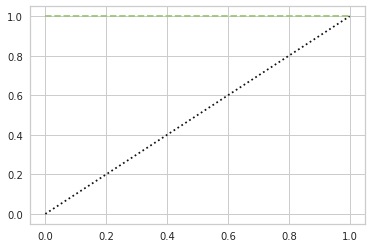

In [0]:
rf = joblib.load('rf_ver1.pkl')
import_AUC_plot(rf, new_X, new_y)

In [0]:
# params = {
#         'n_estimators': range(500, 2000, 500)
# }

# rf = Model('rf', cv)
# rs_rf = rf.rs(params)

- save model

In [0]:
# joblib.dump(best_rf, 'rf_ver1.pkl')

['rf.pkl']

### 2. ExtraTree

extra tree를 이용

In [0]:
ext = ExtraTreesClassifier(random_state = 123, n_estimators = 100)

model_fit(ext, 'ext_ver1.pkl')

####################################
training acc:  0.9976669644554093
 
 
####################################
true acc:  0.7314295795648519


              X  importance
1          열차번호    0.313505
5        누적소요시간    0.115002
9           종착행    0.066159
2             역    0.045907
8           출발행    0.042246
3         출도착구분    0.037912
4        역간소요시간    0.036576
13           하차    0.033344
12           승차    0.030336
11           시간    0.024014
32     지면온도(°C)    0.019460
14       기온(°C)    0.018001
31      시정(10m)    0.017580
20        습도(%)    0.017280
16      풍속(m/s)    0.017263
26    해면기압(hPa)    0.017009
0            요일    0.016721
23    이슬점온도(°C)    0.016672
24    현지기압(hPa)    0.016607
22     증기압(hPa)    0.016469
18     풍향(16방위)    0.015569
7          환승가능    0.013488
29    전운량(10분위)    0.013092
10           방향    0.012510
30  중하층운량(10분위)    0.011337
6          급행여부    0.008740
28     일조 QC플래그    0.007200
17     풍속 QC플래그    0.000000
27   해면기압 QC플래그    0.000000
25   현지기압 QC플래그    0.000000
21     습도 QC플래그    0.000000
19     풍향 QC플래그    0.000000
15     기온 QC플래그    0.000000
33   지면온도 QC플래그    0.000000


findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.


1.0


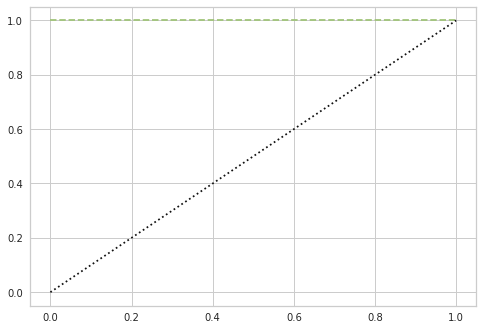

In [0]:
ext = joblib.load('ext_ver1.pkl')
import_AUC_plot(ext, new_X, new_y)

In [0]:
# params = {
#     'n_estimators': range(500, 2000, 500)
# }
# ext = Model('ext', cv)
# rs_ext = ext.rs(params)

- save model

In [0]:
# joblib.dump(best_ext, 'ext_ver1.pkl')

['rf.pkl']

### 3. AdaBoost

In [0]:
adb = AdaBoostClassifier(random_state = 123, n_estimators = 100)

model_fit(adb, 'adb_ver1.pkl')

####################################
training acc:  0.7359221366602426
 
 
####################################
true acc:  0.7144185023853425


              X  importance
1          열차번호        0.42
11           시간        0.10
2             역        0.09
5        누적소요시간        0.06
13           하차        0.06
31      시정(10m)        0.03
26    해면기압(hPa)        0.03
0            요일        0.03
32     지면온도(°C)        0.03
8           출발행        0.02
23    이슬점온도(°C)        0.02
14       기온(°C)        0.02
3         출도착구분        0.02
7          환승가능        0.01
30  중하층운량(10분위)        0.01
12           승차        0.01
29    전운량(10분위)        0.01
4        역간소요시간        0.01
24    현지기압(hPa)        0.01
22     증기압(hPa)        0.01
28     일조 QC플래그        0.00
27   해면기압 QC플래그        0.00
25   현지기압 QC플래그        0.00
17     풍속 QC플래그        0.00
21     습도 QC플래그        0.00
20        습도(%)        0.00
19     풍향 QC플래그        0.00
18     풍향(16방위)        0.00
16      풍속(m/s)        0.00
15     기온 QC플래그        0.00
10           방향        0.00
9           종착행        0.00
6          급행여부        0.00
33   지면온도 QC플래그        0.00
0.7340291981470229


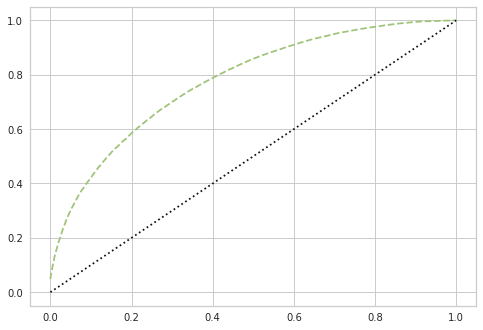

In [0]:
adb = joblib.load('adb_ver1.pkl')
import_AUC_plot(adb, new_X, new_y)

In [0]:
# params = {
#     'n_estimators': range(500, 2000, 500)
# }
# adb = Model('adb', cv)
# rs_adb = adb.rs(params)

- save model

In [0]:
# joblib.dump(best_adb, 'adb_ver1.pkl')

['rf.pkl']

### 4. XGBM

In [0]:
# min_child_weight: 값이 높아지면 under-fitting 되는 경우가 있다.
# gamma: loss function이 감소하기 위한 최소한의 값
params = {
            'learning_rate': np.arange(0.01, 0.1, 0.01),
            'gamma': range(0, 10),
            'max_depth': range(3, 9),
            'min_child_weight': range(1,5)
}

xgb = Model('xgb', cv)
rs_xgb = xgb.rs(params)

[13:39:09] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=8,
              learning_rate=0.06999999999999999, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
joblib.dump(rs_xgb, 'rs_xgb_ver1.pkl')

In [0]:
rs_xgb.best_score_

0.7788623925513767

In [0]:
  xgb = rs_xgb.best_estimator_
  pred = xgb.predict(X_test)


  print('####################################')
  print('training acc: ', accuracy_score(y_test, pred))
  print(' ')
  print(' ')

  new_pred = xgb.predict(new_X)

  print('####################################')
  print('true acc: ', accuracy_score(new_y, new_pred))

####################################
training acc:  0.713931371477837
 
 
####################################
true acc:  0.7974344812513454


              X  importance
3         출도착구분    0.309033
5        누적소요시간    0.109344
2             역    0.047055
28     일조 QC플래그    0.045490
10           방향    0.041584
0            요일    0.039257
8           출발행    0.038933
13           하차    0.038552
1          열차번호    0.034010
11           시간    0.032202
4        역간소요시간    0.022941
29    전운량(10분위)    0.021581
32     지면온도(°C)    0.020766
6          급행여부    0.019907
14       기온(°C)    0.018165
31      시정(10m)    0.018090
7          환승가능    0.017787
22     증기압(hPa)    0.014974
26    해면기압(hPa)    0.014877
9           종착행    0.014758
20        습도(%)    0.014021
30  중하층운량(10분위)    0.013099
24    현지기압(hPa)    0.012580
12           승차    0.011625
23    이슬점온도(°C)    0.010951
18     풍향(16방위)    0.009458
16      풍속(m/s)    0.008960
17     풍속 QC플래그    0.000000
27   해면기압 QC플래그    0.000000
25   현지기압 QC플래그    0.000000
21     습도 QC플래그    0.000000
19     풍향 QC플래그    0.000000
15     기온 QC플래그    0.000000
33   지면온도 QC플래그    0.000000


findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.


0.7974344812513454


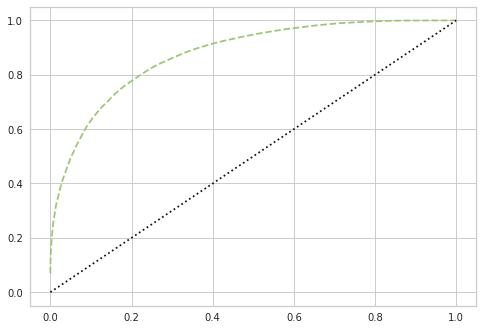

In [0]:
import_AUC_plot(xgb, new_X, new_y)

In [0]:
joblib.dump(xgb, 'xgb_ver1.pkl')

['xgb_ver1.pkl']

### 5. LGBM

In [0]:
# 다음은 randomsearch를 통해 얻은 결과이다.

lgb = LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.09, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=6, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model_fit(lgb, 'lgb_ver1.pkl')

####################################
training acc:  0.767636637747799
 
 
####################################
true acc:  0.7286864520308163
저장완료


              X  importance
1          열차번호         542
5        누적소요시간         214
2             역         194
11           시간         190
8           출발행         154
9           종착행         126
0            요일         117
14       기온(°C)         103
3         출도착구분          90
4        역간소요시간          89
32     지면온도(°C)          89
31      시정(10m)          66
26    해면기압(hPa)          59
22     증기압(hPa)          54
24    현지기압(hPa)          50
13           하차          48
10           방향          41
20        습도(%)          36
12           승차          33
6          급행여부          32
16      풍속(m/s)          31
28     일조 QC플래그          30
29    전운량(10분위)          29
18     풍향(16방위)          27
23    이슬점온도(°C)          21
7          환승가능          18
30  중하층운량(10분위)          17
17     풍속 QC플래그           0
27   해면기압 QC플래그           0
25   현지기압 QC플래그           0
21     습도 QC플래그           0
19     풍향 QC플래그           0
15     기온 QC플래그           0
33   지면온도 QC플래그           0


findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.


0.7793049558644143


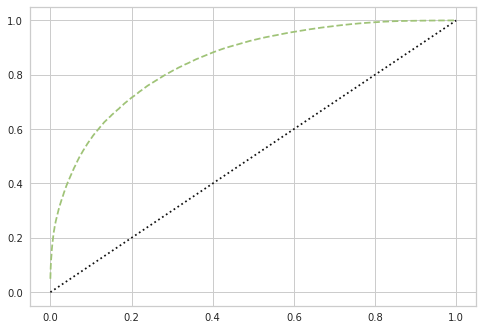

In [0]:
import_AUC_plot(lgb, new_X, new_y)

### 6. Logistic

In [0]:
lr = LogisticRegression(random_state=0)
model_fit(lr, 'lr_ver1.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####################################
training acc:  0.7001539748370043
 
 
####################################
true acc:  0.7012472771151278
저장완료


### Voting

- RandomForest, ExtraTree, Adaboost

In [0]:
voting = VotingClassifier(
   estimators=[('rf', rf), ('ext', ext), ('adb', adb)],
   voting='hard')

model_fit(voting, 'voting_ver1.pkl')

####################################
training acc:  0.9977569437877075
 
 
####################################
true acc:  0.7328857346177166
저장완료


- RandomForest, ExtraTree, LightGBM

In [0]:
voting1 = VotingClassifier(
   estimators=[('rf', rf), ('ext', ext), ('lgb', lgb)],
   voting='hard')

model_fit(voting1, 'voting_ver2.pkl')

####################################
training acc:  0.9977675025869058
 
 
####################################
true acc:  0.7341200432633409
저장완료


- LightGBM, Adaboost, XGboost

In [0]:
# votingclassifier가 안돼서 직접 구현
def vote(X, y):
  lgb_pred = lgb.predict(X)
  xgb_pred = xgb.predict(X)
  adb_pred = adb.predict(X)

  voting = pd.DataFrame({
                        'lgb': lgb_pred,
                        'xgb': xgb_pred,
                        'adb': adb_pred    
  })
  pred = voting.apply(lambda x: 1 if x[0] + x[1] + x[2] >= 2 else 0, axis = 1)
  print(accuracy_score(pred, y))

In [0]:
vote(X_test, y_test) # test
vote(new_X, new_y) # true

0.7530957940171089
0.7386971888702883


### Stacking

In [0]:
# Initialize 1-st level models. 
models = [xgb, adb, lgb] 


# Compute stacking features 
S_train, S_test = stacking(models, X_train, y_train, X_test, 
                           regression = False, metric = accuracy_score, 
                           n_folds = cv, stratified = True, shuffle = True, 
                           random_state = 0, verbose = 2) 


# Initialize 2-nd level model 

model = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3) 

# Fit 2-nd level model 
model.fit(S_train, y_train) 

# Predict 
y_pred = model.predict(S_test)

accuracy_score(y_pred, y_test)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    fold  0:  [0.77928419]
    fold  1:  [0.77876526]
    fold  2:  [0.77859794]
    fold  3:  [0.77868361]
    fold  4:  [0.77810024]
    ----
    MEAN:     [0.77868625] + [0.00037815]
    FULL:     [0.77868625]

model  1:     [AdaBoostClassifier]
    fold  0:  [0.73576646]
    fold  1:  [0.73493776]
    fold  2:  [0.73633061]
    fold  3:  [0.73589505]
    fold  4:  [0.73497477]
    ----
    MEAN:     [0.73558093] + [0.00054336]
    FULL:     [0.73558093]

model  2:     [LGBMClassifier]
    fold  0:  [0.76712157]
    fold  1:  [0.76719619]
    fold  2:  [0.76681179]
    fold  3:  [0.76755318]
    fold  4:  [0.76590595]
    ----
    MEAN:     [0.76691774] + [0.00055818]
    FULL:     [0.76691774]

[22:53:06] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old b

0.7790832942351711

In [0]:
joblib.dump(model, 'stacking_test.pkl')

['stacking_test.pkl']

In [0]:
# Compute stacking features 
S_train, S_test = stacking(models, X_train, y_train, new_X, 
                           regression = False, metric = accuracy_score, 
                           n_folds = cv, stratified = True, shuffle = True, 
                           random_state = 0, verbose = 2) 


# Initialize 2-nd level model 

model = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3) 

# Fit 2-nd level model 
model.fit(S_train, y_train) 

# Predict 
y_pred = model.predict(S_test)

accuracy_score(y_pred, new_y)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    fold  0:  [0.77928419]
    fold  1:  [0.77876526]
    fold  2:  [0.77859794]
    fold  3:  [0.77868361]
    fold  4:  [0.77810024]
    ----
    MEAN:     [0.77868625] + [0.00037815]
    FULL:     [0.77868625]

model  1:     [AdaBoostClassifier]
    fold  0:  [0.73576646]
    fold  1:  [0.73493776]
    fold  2:  [0.73633061]
    fold  3:  [0.73589505]
    fold  4:  [0.73497477]
    ----
    MEAN:     [0.73558093] + [0.00054336]
    FULL:     [0.73558093]

model  2:     [LGBMClassifier]
    fold  0:  [0.76712157]
    fold  1:  [0.76719619]
    fold  2:  [0.76681179]
    fold  3:  [0.76755318]
    fold  4:  [0.76590595]
    ----
    MEAN:     [0.76691774] + [0.00055818]
    FULL:     [0.76691774]

[02:09:15] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old b

0.7270209582316537

In [0]:
joblib.dump(model, 'stacking_new_y.pkl')

['stacking_new_y.pkl']

### Deep Learning

In [0]:
Nin = X_train.shape[1]
Nout = 1


callbacks = [
  # `val_loss`가 2번의 에포크에 걸쳐 향상되지 않으면 훈련을 멈춥니다.
  callbacks.EarlyStopping(patience = 2, monitor = 'val_loss')
]

- activation = relu

In [0]:
model_1 = models.Sequential()
model_1.add(layers.Dense(100, activation = 'relu', input_shape = (Nin,)))
model_1.add(layers.Dense(500, activation = 'relu'))
model_1.add(layers.Dense(500, activation = 'relu'))
model_1.add(layers.Dense(100, activation = 'relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(Nout, activation = 'sigmoid'))

model_1.compile(optimizer = 'sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_1 = model_1.fit(X_train, y_train, batch_size = 300, validation_split = 0.3,
                        epochs = 300, callbacks = callbacks, verbose = 1)

Epoch 1/300
10320/10320 [==============================] - 33s 3ms/step - loss: 0.5879 - accuracy: 0.6962 - val_loss: 0.5636 - val_accuracy: 0.7098
Epoch 2/300
10320/10320 [==============================] - 33s 3ms/step - loss: 0.5589 - accuracy: 0.7111 - val_loss: 0.5532 - val_accuracy: 0.7129
Epoch 3/300
10320/10320 [==============================] - 33s 3ms/step - loss: 0.5476 - accuracy: 0.7157 - val_loss: 0.5425 - val_accuracy: 0.7178
Epoch 4/300
10320/10320 [==============================] - 34s 3ms/step - loss: 0.5395 - accuracy: 0.7190 - val_loss: 0.5387 - val_accuracy: 0.7191
Epoch 5/300
10320/10320 [==============================] - 33s 3ms/step - loss: 0.5323 - accuracy: 0.7219 - val_loss: 0.5558 - val_accuracy: 0.7099
Epoch 6/300
10320/10320 [==============================] - 33s 3ms/step - loss: 0.5257 - accuracy: 0.7246 - val_loss: 0.5180 - val_accuracy: 0.7287
Epoch 7/300
10320/10320 [==============================] - 33s 3ms/step - loss: 0.5196 - accuracy: 0.7285 - val_

findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.


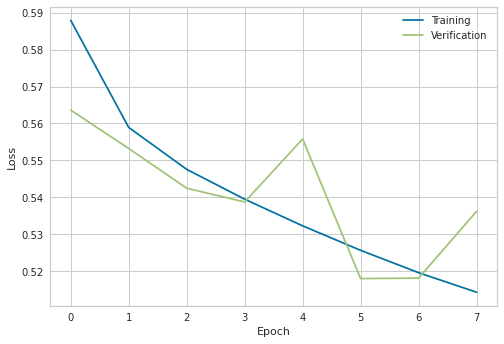

In [0]:
history_1 = history_1.history

"""Cost/Loss  변화 추이 그래프"""
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Verification'], loc=0)
plt.show() 


In [0]:
model_1.save('model_ver1.h5')
model_1.save_weights('model_weight_ver1.h5')

In [0]:
pred = model_1.predict(X_test)


print('####################################')
print('training acc: ', accuracy_score(y_test, 
                                        list(map(lambda x: 1 if x >= 0.5 else 0, pred))
                                       ))
print(' ')
print(' ')

new_pred = model_1.predict(new_X)

print('####################################')
print('true acc: ', accuracy_score(new_y, 
                                   list(map(lambda x: 1 if x >= 0.5 else 0, new_pred))
                                       ))

####################################
training acc:  0.7225730600042786
 
 
####################################
true acc:  0.7062891810707743
